In [311]:
import spacy
import tweepy

# 認証に必要なキーとトークン #dd
API_KEY = 'XXXXX'
API_SECRET = 'XXXXX'
ACCESS_TOKEN = 'XXXXX'
ACCESS_TOKEN_SECRET = 'XXXXX'
BEARER_TOKEN='XXXXX'

# APIの認証
auth = tweepy.OAuthHandler(API_KEY, API_SECRET)
auth.set_access_token(ACCESS_TOKEN, ACCESS_TOKEN_SECRET)

api = tweepy.API(auth)
api=tweepy.API(auth,wait_on_rate_limit=True)
client = tweepy.Client(
    consumer_key=API_KEY,
    consumer_secret=API_SECRET,
    access_token=ACCESS_TOKEN,
    access_token_secret=ACCESS_TOKEN_SECRET,
    bearer_token=BEARER_TOKEN
)

In [378]:
#モデルインポート

#感情モデル
from transformers import pipeline 
from transformers import AutoModelForSequenceClassification 
from transformers import BertJapaneseTokenizer 
import torch
import gensim
import spacy

emotionModel = AutoModelForSequenceClassification.from_pretrained('daigo/bert-base-japanese-sentiment') 
tokenizer = BertJapaneseTokenizer.from_pretrained('cl-tohoku/bert-base-japanese-whole-word-masking') 
nlp = pipeline("sentiment-analysis", model=emotionModel, tokenizer=tokenizer) 

#形態素解析
from janome.tokenizer import Tokenizer
import collections

tokenizer = Tokenizer() 

#固有表現抽出
nlpUnique = spacy.load('ja_ginza')

#単語ベクトルモデル
# modelWords = gensim.models.KeyedVectors.load_word2vec_format('cc.ja.300.vec.gz', binary=False)
# from gensim.models.doc2vec import Doc2Vec
# model = Doc2Vec.load("jawiki.doc2vec.dbow300d/jawiki.doc2vec.dbow300d.model")
from gensim.models import KeyedVectors
model_dir = 'entity_vector/entity_vector.model.bin'
vectorModel = KeyedVectors.load_word2vec_format(model_dir, binary=True)


In [397]:
#ツイートコーパスから単語抽出
from janome.tokenizer import Tokenizer
from gensim.models import Phrases
import re
import csv
 
def isNoun(word):
    if word.find(u' ') >= 0:
        return False

    if bool(re.search(r'[a-zA-Z0-9]',word)):
        return False

    if word.find(u'\n') >= 0 or word.find(u'\r') >= 0:
        return False
    tokens = tokenizer.tokenize(word)
    for num, token in enumerate(tokens):
        surFace = token.surface
        pre = token.part_of_speech.split(',')[0]
        next = token.part_of_speech.split(',')[1]
        baseForm = token.base_form
        inflForm = token.infl_form
 
        if surFace == '_':
            continue
        if (pre == u'名詞' and next != u'数' and baseForm != '*'):
            continue
        if (pre == u'接頭詞' and next == u'名詞接続' and baseForm != '*'):
            continue
        return False

    for ch in word: #ddl
        if (ch < u'ぁ' or ch > u'ん') and ch != '_':
            return True
    return False
 
def findNewWords(tweetList):
    tokenizer = Tokenizer()
    corpus = []
    for tweet in tweetList:
        code_regex = re.compile('[!"#$%&\'\\\\()*+,-./:;<=>?@[\\]^_`{|}~「」〔〕“”〈〉『』【】＆＊・（）＄＃＠。、？！｀＋￥％]')
        tweet = code_regex.sub('', tweet)
        tokens = tokenizer.tokenize(tweet.replace('_', ' '))
        corpus.append([token.surface for token in tokens])

    for i in range(10):
        phrases = Phrases(corpus)
        transformed = phrases[corpus]
        corpus = transformed
    
    phraseWords = []
    for sentence in transformed:
        for word in sentence:
            if word.find('_') >= 0 and word not in phraseWords:
                phraseWords.append(word)
                if isNoun(word):
                    yield word.replace('_', '')

In [398]:
#イベント来場者特性
import re
import pandas as pd

def attendeeCharacter(event_word):
    tweetUserData=[]
    descpNoun=[]
    eventNounList=[]

    for i in range(100):
        if(i==0):
            print(f'token {i+1}')
            tweets = client.search_recent_tweets(query=f'{event_word}& -is:retweet',  # 検索ワード
                                            expansions=['author_id'],
                                            user_fields=['description'],
                                            tweet_fields=['created_at','context_annotations'],
                                            max_results=100,  # 取得件数
                                            )
        else:
            print(f'token {i+1}')
            
            tweets = client.search_recent_tweets(query=f'{event_word}& -is:retweet',  # 検索ワード
                                            expansions=['author_id'],
                                            user_fields=['description'],
                                            tweet_fields=['created_at','context_annotations'],
                                            max_results=100,  # 取得件数
                                            next_token=token
                                            )
        
                
        for j in range (len(tweets[0])):
            id=tweets[0][j].author_id #user_id
            user = api.get_user(user_id=f"{id}")
            #ツイート文から記号の削除
            text=tweets[0][j].text.replace('\n',"")
            code_regex = re.compile('[!"#$%&\'\\\\()*+,-./:;<=>?@[\\]^_`{|}~「」〔〕“”〈〉『』【】＆＊・（）＄＃＠。、？！｀＋￥％]')
            cleaned_text = code_regex.sub('', text)

            eventNoun=None
            annotation=None
            adjective=None

            #descriptionの固有表現抽出
            for ent in nlpUnique(user.description).ents:
                # if(ent.label_=="Person"):
                descpNoun.append(ent.text)

            #ツイート文の固有表現抽出
            if('代行' in cleaned_text):
                continue
            elif('郵送' in cleaned_text):
                continue
            elif('譲' in cleaned_text):
                continue
            elif('送料' in cleaned_text):
                continue
            elif('手渡し' in cleaned_text):
                continue
            if(cleaned_text):
                for ent in nlpUnique(cleaned_text).ents:
                    # if(ent.label_=="Person"):
                    if(bool(re.search(r'[a-zA-Z0-9]',ent.text))==False):
                        eventNoun=ent.text
                        eventNounList.append(eventNoun)
            
            #ツイート文のアノテーション
            if(tweets[0][j].context_annotations):
                annotation=tweets[0][j].context_annotations[0]['entity']['id']
            
            #ツイート文の形態素解析→形容詞抽出
            for token in tokenizer.tokenize(cleaned_text):
                pos = token.part_of_speech.split(',')  
                # if '名詞' in pos:  
                #     noun=token.surface
                #     # if(peopleListCount in noun):
                #     person=set(peopleListCount)&set(noun)

                #ここは単語ベクトルで置き換えたい（形容詞は事前定義）
                if '形容詞' in pos:
                    if('良' in token.surface):
                        adjective="良い"
                    elif('可愛' in token.surface) or ('かわ' in token.surface):
                        adjective="可愛い"
                    elif('美味' in token.surface):
                        adjective="美味しい"
                    elif('すご' in token.surface):
                        adjective="すごい"
                    else:
                        adjective=token.surface

            #ユーザデータの統合
            tweetUserData.append([
                id,
                user.description,
                user.location,
                user.followers_count,
                user.friends_count,
                user.created_at,
                user.favourites_count,
                user.verified,
                annotation, #ツイートアノテーション
                text,
                nlp(text)[0]['label'], #ネガポジ判定
                eventNoun,
                # modelWords[noun],
                adjective,
                tweets[0][j].created_at.strftime('%Y-%m-%d %H')
                ])
        if('next_token' not in tweets.meta):
            break
        token=tweets.meta['next_token']
    
    dfUserInfo = pd.DataFrame(tweetUserData,columns=['user_id', 'description','location','followers_count','friends_count','created_at','favourites_count','verified', 'tweet_annotation', 'text', 'emotion','noun','adjective','tweet_time'])
    
    if (event_word=="セーラームーンミュージアム"):
        eventKeywords=["セーラームーン","ミュージアム","アニメ"]
    elif (event_word=="なんばグランド花月"):
        eventKeywords=["お笑い","漫才","吉本新喜劇"]
    elif (event_word=="Ultra Japan"):
        eventKeywords=["音楽","フェス","ダンス"]
    elif (event_word=="鈴木敏夫とジブリ展"):
        eventKeywords=["ジブリ","アニメ","鈴木敏夫"]
    elif (event_word=="冨樫義博展"):
        eventKeywords=["冨樫義博","ミュージアム","アニメ"]

    return event_word, dfUserInfo, eventKeywords

In [399]:
#イベント来場者特性(類似度計算に必要な部分のみ)
import re
import pandas as pd

def attendeeCharacterForSimilar(event_word):
    tweetUserData=[]

    for i in range(100):
        if(i==0):
            print(f'token {i+1}')
            tweets = client.search_recent_tweets(query=f'{event_word}& -is:retweet',  # 検索ワード
                                            expansions=['author_id'],
                                            user_fields=['description'],
                                            max_results=100,  # 取得件数
                                            )
        else:
            print(f'token {i+1}')
            
            tweets = client.search_recent_tweets(query=f'{event_word}& -is:retweet',  # 検索ワード
                                            expansions=['author_id'],
                                            user_fields=['description'],
                                            max_results=100,  # 取得件数
                                            next_token=token
                                            )
        
                
        for j in range (len(tweets[0])):
            id=tweets[0][j].author_id #user_id
            user = api.get_user(user_id=f"{id}")
            #ツイート文から記号の削除
            text=tweets[0][j].text.replace('\n',"")
            code_regex = re.compile('[!"#$%&\'\\\\()*+,-./:;<=>?@[\\]^_`{|}~「」〔〕“”〈〉『』【】＆＊・（）＄＃＠。、？！｀＋￥％]')
            cleaned_text = code_regex.sub('', text)


            #ユーザデータの統合
            tweetUserData.append([
                id,
                user.description,
                text,
                ])
        if('next_token' not in tweets.meta):
            break
        token=tweets.meta['next_token']
    
    dfUserInfo = pd.DataFrame(tweetUserData,columns=['user_id', 'description', 'text'])
    
    if (event_word=="セーラームーンミュージアム"):
        eventKeywords=["セーラームーン","ミュージアム","アニメ"]
    elif (event_word=="なんばグランド花月"):
        eventKeywords=["お笑い","漫才","吉本新喜劇"]
    elif (event_word=="Ultra Japan"):
        eventKeywords=["音楽","フェス","ダンス"]
    elif (event_word=="鈴木敏夫とジブリ展"):
        eventKeywords=["ジブリ","アニメ","鈴木敏夫"]
    elif (event_word=="冨樫義博展"):
        eventKeywords=["冨樫義博","ミュージアム","アニメ"]

    return event_word, dfUserInfo, eventKeywords

In [400]:
#来場者に何好きの人が多いか（固有表現抽出→頻出単語）
import collections
import re

def attendeeLike(dfUserInfo):
    descpNounList = list(set(dfUserInfo['description'].values.tolist())) #ユーザ重複の削除
    descpIndexList = []
    tokenizer = Tokenizer("customDictionary.csv", udic_enc="utf8")
    for descpindex in descpNounList:
        for token in tokenizer.tokenize(f"{descpindex}"):
            pos = token.part_of_speech.split(',')  
            if ('名詞' in pos[0]) and ('一般' in pos[1]):  
                noun=token.surface
                descpIndexList.append(noun)
    descpNounCount = collections.Counter(descpIndexList) 
    descpNounCount = sorted(descpNounCount.items(), key=lambda x:x[1] , reverse=True)
    for tn in descpNounCount[:]:
        if(tn[1]<=3):
            descpNounCount.remove(tn)
        elif(re.search(r'[a-zA-Z0-9]', tn[0])):
            descpNounCount.remove(tn)

    descpNounCountList=[]
    for i in descpNounCount:
        descpNounCountList.append(i[0])
    descpNounCountList = list(set(descpNounCountList))
    return descpNounCountList

In [401]:
#イベント注目ワード（固有表現抽出→頻出単語）
import collections

def eventAttentionWords(dfUserInfo):
    descpNounList = list(dfUserInfo['text'].values.tolist()) 
    userDescpNoun=[]
    tokenizer = Tokenizer("customDictionary.csv", udic_enc="utf8")
    for descpindex in descpNounList:
        for token in tokenizer.tokenize(f"{descpindex}"):
            pos = token.part_of_speech.split(',')  
            if ('名詞' in pos[0]) and ('一般' in pos[1]):  
                noun=token.surface
                userDescpNoun.append(noun)
    # for descpindex in descpNounList:
    #     for ent in nlpUnique(descpindex).ents:
    #         descpIndexList.append(ent.text)
    eventNounCount = collections.Counter(userDescpNoun)
    eventNounCount = sorted(eventNounCount.items(), key=lambda x:x[1] , reverse=True)
    for tn in eventNounCount[:]:
        if(tn[1]<=5):
            eventNounCount.remove(tn)
        elif(re.search(r'[a-zA-Z0-9]', tn[0])):
            eventNounCount.remove(tn)
    eventNounCount
    eventNounCountList=[]
    for i in eventNounCount:
        eventNounCountList.append(i[0])
    eventNounCountList = list(set(eventNounCountList))
        
    return eventNounCountList

In [402]:
#ユーザの特性
from janome.tokenizer import Tokenizer
import collections

def userCharacter(user):
    user_name=user
    user = api.get_user(screen_name=f"{user}")
    userDescpNoun=[]

    tokenizer = Tokenizer("customDictionary.csv", udic_enc="utf8")
    for token in tokenizer.tokenize(f"{user.description}"):
        pos = token.part_of_speech.split(',')  
        if ('名詞' in pos[0]) and ('一般' in pos[1]):  
            noun=token.surface
            userDescpNoun.append(noun)
            userDescpNoun=list(set(userDescpNoun))
    # for ent in nlpUnique(user.description).ents:
    #     userDescpNoun.append(ent.text)

    #過去100件のツイート
    # recentTweetNounCountList=None
    tweets =tweepy.Cursor(api.user_timeline, screen_name=f"{user_name}").items(50)
    tweet_data = []
    tweetText = None
    for tweet in tweets:
        if not "@" in tweet.text:
            tweetText = tweet.text
        for token in tokenizer.tokenize(f"{tweetText}"):
            pos = token.part_of_speech.split(',')  
            if ('名詞' in pos[0]) and ('一般' in pos[1]):  
                noun=token.surface
                tweet_data.append(noun)
    recentTweetNounCount = collections.Counter(tweet_data) 
    recentTweetNounCount = sorted(recentTweetNounCount.items(), key=lambda x:x[1] , reverse=True)
    for tn in recentTweetNounCount[:]:
        if(tn[1]<=3):
            recentTweetNounCount.remove(tn)
        elif(re.search(r'[a-zA-Z0-9]', tn[0])):
            recentTweetNounCount.remove(tn)

    recentTweetNounCountList=[]
    for i in recentTweetNounCount:
        recentTweetNounCountList.append(i[0])
    recentTweetNounCountList = list(set(recentTweetNounCountList))
    
    #フォローユーザのディスクリプション
    # followNounCountList=None
    friendsIDs = api.get_friend_ids(screen_name=f"{user_name}")
    friendDatas =[]
    for friendsID in friendsIDs:
        data = api.get_user(user_id=f"{friendsID}")
        for token in tokenizer.tokenize(f"{data.description}"):
            pos = token.part_of_speech.split(',')  
            if ('名詞' in pos[0]) and ('一般' in pos[1]):  
                noun=token.surface
                friendDatas.append(noun)
    
    followNounCount = collections.Counter(friendDatas) 
    followNounCount = sorted(followNounCount.items(), key=lambda x:x[1] , reverse=True)
    for tn in followNounCount[:]:
        if(tn[1]<=3):
            followNounCount.remove(tn)
        elif(re.search(r'[a-zA-Z0-9]', tn[0])):
            followNounCount.remove(tn)

    followNounCountList=[]
    for i in followNounCount:
        followNounCountList.append(i[0])
    followNounCountList = list(set(followNounCountList))
    
    #フォロワーのディスクリプション（最大5000）
    # followerIDs = api.get_follower_ids(screen_name=f"{user_name}")
    # followerDatas = []
    # for followerID in followerIDs:
    #     data = api.get_user(user_id=f"{followerID}")
    #     followerDatas.append(data.description)
    # followerNounCount = collections.Counter(followerDatas) 
    # followerNounCount = sorted(followerNounCount.items(), key=lambda x:x[1] , reverse=True)
    # for tn in followerNounCount[:]:
    #     if(tn[1]<=3):
    #         followerNounCount.remove(tn)
    #     elif(re.search(r'[a-zA-Z0-9]', tn[0])):
    #         followerNounCount.remove(tn)

    # followerNounCountList=[]
    # for i in followerNounCount:
    #     followerNounCountList.append(i[0])
    # followerNounCountList = list(set(followerNounCountList))

    return userDescpNoun, recentTweetNounCountList, followNounCountList

In [ ]:
# イベントワードとイベントデータの単語類似度
def eventWordSimilarity(event_data, eventKeywords):
    
    eventWordDegree=[]
    
    for key1 in eventKeywords:
        for j in range (len(event_data)):
            try:
                similarity=vectorModel.similarity(key1,event_data[j])
                # print(f"{event_data[j]} = {similarity}")
                if(similarity>0.7):
                    eventWordDegree.append(event_data[j])
                    # eventWordDegree.append(f"{event_data[j]} : {similarity}")
            except KeyError:
                pass
    return eventWordDegree

In [455]:
# ユーザ分析の結果とイベントデータの単語類似度
import numpy as np
import statistics
# userDescpNoun ：ユーザの好きなもの
# descNounList ：来場者に何好きの人が多いか 
# eventNounCount ：イベント注目度ワード
def eventSimilarityUser(userDescpNoun, eventNounCountList, descpNounCountList, eventKeywords, tweetCounts):
    relatedWords=[]
    recomendPoints=[]
    similarityList=[]
    similarityList2=[]
    similarityList3=[]
    similarityWordList=[]
    similarityWordList2=[]
    moreSimilarityList=[]
    moreSimilarityList2=[]
    moreSimilarityWordList=[]
    moreSimilarityWordList2=[]
    recommendDegree=0
    recommendFlag=False

    eventWord = eventWordSimilarity(eventNounCountList, eventKeywords)

    # print('Recommend Degree')
    for i in range(len(userDescpNoun)):
        for j in range (len(eventWord)):
            try:
                similarity=vectorModel.similarity(userDescpNoun[i],eventWord[j])
                # print(f"{userDescpNoun[i]} & {eventWord[j]} = {similarity}")
            
                if(similarity>0.8):
                    moreSimilarityWordList.append(eventWord[j])
                    moreSimilarityList.append(similarity)
                elif(similarity>0.5):
                    relatedWords.append(f"{eventWord[j]} : {similarity}")
                    similarityList.append(similarity)
                    similarityWordList.append(eventWord[j])
                else:
                    similarityList3.append(similarity)
                        
            except KeyError:
                continue

    # print('Recommend Point')
    for i in range(len(userDescpNoun)):
        for j in range (len(descpNounCountList)):
            try:
                similarity=vectorModel.similarity(userDescpNoun[i],descpNounCountList[j])
                # print(f"{userDescpNoun[i]} & {descpNounCountList[j]} = {similarity}")
                if(similarity>0.8):
                    moreSimilarityWordList2.append(descpNounCountList[j])
                    moreSimilarityList2.append(similarity)
                
                if(similarity>0.5):
                    recomendPoints.append(f"{descpNounCountList[j]} : {similarity}")
                    similarityList2.append(similarity)
                    similarityWordList2.append(descpNounCountList[j])
            except KeyError:
                continue
    
    #類似度計算
    #イベントツイートとの関連度
    # if len(moreSimilarityWordList)>=5 or len(similarityList)>=20:
    #     recommendDegree+=65
    # elif len(moreSimilarityWordList)>=2 or len(similarityList)>=5:
    #     recommendDegree+=55
    # elif len(similarityList)>=2:
    #     recommendDegree+=45
    
    #イベントユーザとの関連度
    # if len(moreSimilarityWordList2)>=5 or len(similarityList2)>=20:
    #     recommendDegree+=25
    # elif len(moreSimilarityWordList2)>=2 or len(similarityList2)>=5:
    #     recommendDegree+=15
    # elif len(similarityList)>=2:
    #     recommendDegree+=5
    
    if moreSimilarityList:
        recommendDegree+=65*statistics.mean(moreSimilarityList)
    if similarityList:
        recommendDegree+=25*(statistics.mean(similarityList)/0.8)
    if not(moreSimilarityList) and not(similarityList):
        recommendDegree+=statistics.mean(similarityList3)*100

    if(recommendDegree>50):
        recommendFlag=True
    
    #ツイート数
    if(recommendFlag):
        if (tweetCounts>1000):
            recommendDegree+=10
        else:
            recommendDegree+=10*tweetCounts/1000
    # recommendDegree=np.mean(similarityList)
    similarityCount = len(similarityList)

    return relatedWords, recomendPoints, recommendDegree, similarityCount, similarityWordList, moreSimilarityWordList, similarityWordList2, moreSimilarityWordList2

In [425]:
#テキスト不要文字削除
def format_text(text):
    text=re.sub(r'https?://[\w/:%#\$&\?\(\)~\.=\+\-…]+', "", text)
    text=re.sub(r'[!-~]', "", text)
    text=re.sub(r'[︰-＠]', "", text)
    text=re.sub('\n', " ", text)
    return text

In [426]:
#絵文字の削除
import pandas as pd
pd.set_option("display.max_colwidth", 280)
import emoji

def remove_emoji(text):
    textList=emoji.emoji_list(text)
    emojiList=[]
    for emojiIndex in textList:
        text= text.replace(emojiIndex['emoji'],'')
        emojiList.append(emojiIndex['emoji'])
    return text

In [463]:
#おすすめツイート表示
def attendeeRelatedTweets(dfUserInfo,userDescpNoun):
    likePointsDataset=[]
    descpNounList = list(dfUserInfo['text'].values.tolist()) 
    tokenizer = Tokenizer("customDictionary.csv", udic_enc="utf8")
    # tokenizer = Tokenizer()
    for str in descpNounList:
        pre,next=None,None
        pre_text= str
        tokenList=[]
        str=str.replace('\n',"")
        code_regex = re.compile('[!"#$%&\'\\\\()*+,-./:;<=>?@[\\]^_`{|}~「」〔〕“”〈〉『』【】＆＊・（）＄＃＠。、？！｀＋￥％]')
        str = code_regex.sub('', str)
        str = format_text(str)
        str = remove_emoji(str)
        for token in tokenizer.tokenize(str):
            tokenList.append(token)
        tokenFlag=False
        for num, token in enumerate(tokenList):
            surFace = token.surface
            if(token.part_of_speech.split(',')[0] == u'名詞'):
                pre=surFace
                tokenFlag=True
            if(tokenFlag):
                if(token.part_of_speech.split(',')[0] =='形容詞'):
                    next=surFace
                    tokenFlag=False
            if(pre and next):
                likePointsDataset.append([pre,next,pre_text])
                pre,next,pre_text=None,None,None
    #ツイート量が大規模になればツイートのライク数、コメント数、リツイート数も考慮
    relatedTweets=[]
    relatedWords=[]
    for i in range(len(userDescpNoun)):
        for likepoint in likePointsDataset:
            try:
                similarity=vectorModel.similarity(userDescpNoun[i],likepoint[0])
                # print(f"{userDescpNoun[i]} & {eventWord[j]} = {similarity}")
                if(similarity>0.75):
                    relatedTweets.append(likepoint[2])  
                    relatedWords.append(likepoint[0]) 
                    continue             
            except KeyError:
                continue
    return relatedTweets, relatedWords

In [482]:
#おすすめ度の表示
def eventRecommendation(user_name, event_attendee):
    from gensim.models import KeyedVectors
    model_dir = 'entity_vector/entity_vector.model.bin'
    vectorModel = KeyedVectors.load_word2vec_format(model_dir, binary=True)
    
    user= userCharacter(user_name)[0]

    eventRecommendPoints = eventAttentionWords(event_attendee[1])
    attendeeLikePoints = attendeeLike(event_attendee[1])

    tweetCounts=len(event_attendee[1])
    
    recommendDegree = eventSimilarityUser(user, eventRecommendPoints, attendeeLikePoints, event_attendee[2], tweetCounts)

    relatedTweets=attendeeRelatedTweets(event_attendee[1], user)[0]

    isRecommend = False

    # if(recommendDegree[0]):
    # print(f"Recommend Degree {recommendDegree[2]}")
    # print(recommendDegree[3])
    
    if(recommendDegree[2]>50):
        isRecommend =True
        print(recommendDegree[6])
        print(recommendDegree[7])
        print(f"Recommend you {event_attendee[0]} {recommendDegree[2]} %")
        if(relatedTweets):
            print(f"Here are your related tweets")
            for related_tweet in relatedTweets:
                if not related_tweet == None:
                    print(f"・{related_tweet} \n")
    else:
        print(f"We don't recommend you {event_attendee[0]} (Recommend Degree {recommendDegree[2]})")
        # print(recommendDegree[4])
        # print(recommendDegree[5])
    # return event_attendee[0], recommendDegree[2], isRecommend

In [407]:
#ユーザ辞書の作成
def createCustomerDictionary(dfUserInfo):
    tweetList = list(dfUserInfo['text'].values.tolist()) 
    for newWord in findNewWords(tweetList):
        line = [newWord,-1,-1,1000,"名詞","一般","*","*","*","*",newWord,newWord,newWord]
        with open('customDictionary2.csv', mode='a', newline="") as f:
            writer = csv.writer(f)
            writer.writerow(line)

In [408]:
#ツイートコーパス作成
def createCorpus(dfUserInfo):
    descpNounList = list(dfUserInfo['text'].values.tolist()) 
    return descpNounList

# corpus =createCorpus(attendee1[1])+createCorpus(attendee2[1])+createCorpus(attendee3[1])+createCorpus(attendee4[1])+createCorpus(attendee5[1])
# for x in modelTweets.wv.most_similar("セーラームーン"):
#   print(x)

In [409]:
#ツイートオリジナルWord2vec
from gensim.models import word2vec
def createTweetCorpus(corpus_list):
  tokenizer = Tokenizer("customDictionary.csv", udic_enc="utf8")

  sentences = []
  for str in corpus_list:
    str=str.replace('\n',"")
    code_regex = re.compile('[!"#$%&\'\\\\()*+,-./:;<=>?@[\\]^_`{|}~「」〔〕“”〈〉『』【】＆＊・（）＄＃＠。、？！｀＋￥％]')
    str = code_regex.sub('', str)
    str = format_text(str)
    str = remove_emoji(str)
    sentences.append(list(tokenizer.tokenize(str, wakati=True)))

  modelTweets = word2vec.Word2Vec(
      sentences,
      min_count=20,
      window=15,
      epochs=1000
  )
  return modelTweets

In [410]:
#Word2vecの追加学習
from gensim.models import word2vec
def addWord2vec(corpus_list):
    model_dir = 'entity_vector/entity_vector.model.bin' #実際はbinaryファイルはできない
    baseModel = word2vec.Word2Vec.load(model_dir) 
    baseModel.build_vocab(corpus_list, update=True)
    expandVectorModel = baseModel.train(corpus_list, total_examples=baseModel.corpus_count, epochs=baseModel.iter)
    return expandVectorModel

In [61]:
user = userCharacter('chibi_rabbit_')[0]
user2 = userCharacter('_yukinami_')[0]
user3 = userCharacter('mel33325')[0]
user4 = userCharacter('shirtkickbottom')[0]
user5 = userCharacter('MmEDM02')[0]
user6 = userCharacter('nonbiri_pontyo')[0]
print(user,user2,user3,user4,user5,user6)

['DM', 'ネイル', '無断', 'セラムン', 'グッズ', '写真', 'セーラームーン', '情報', '無言', 'アカウント'] ['イラスト', 'フィギュア', 'スケート', 'セーラームーン'] ['他', '需要', 'ゲーム', '偽物', 'アニメ', 'グッズ', '花嫁', 'ツイート', '実績'] ['だい', 'すき', 'お笑い', 'コント', '相互', '漫才'] ['ダンスミュージック'] ['仲間', '筆', '猫', '募集中', '無言', '絵描き', 'ペン', 'ジブリ']


In [ ]:
attendee1 = attendeeCharacter("セーラームーンミュージアム")
attendee2 = attendeeCharacter("なんばグランド花月")
attendee3 = attendeeCharacter("Ultra Japan")
attendee4 = attendeeCharacter("鈴木敏夫とジブリ展")
attendee5 = attendeeCharacter("冨樫義博展")

In [487]:
createCustomerDictionary(attendee1[1])
createCustomerDictionary(attendee2[1])
createCustomerDictionary(attendee3[1])
createCustomerDictionary(attendee4[1])
createCustomerDictionary(attendee5[1])

In [464]:
# user_name="chibi_rabbit_" #セーラームーン、グッズ好き
user_name="_yukinami_" #セーラームーン、イラスト好き
# user_name ="mel33325" #アニメ好き
# user_name = "shirtkickbottom" #お笑い好き
# user_name = "MmEDM02" #EDM好き
# user_name = "nonbiri_pontyo" #ジブリ好き

In [467]:
eventRecommendation(user_name, attendee1)

Recommend you セーラームーンミュージアム 93.35091412067413 %
Here are your related tweets
・交換していただいて、ムーンとちびムーン揃った🤭💫💓セーラームーンミュージアム、原画が美しすぎて本当にオススメです🥹✨ https://t.co/ZlyA9bZhsj 

・六本木のセーラームーンミュージアム行ってきた！！先日から外部戦士も入って行くなら今！って行ってきた✨原画美しかった……原作読んだことないから原作読みたい！！次はスリーライツ入ったら行こうかなと考え中 https://t.co/C1Qr985rwB 

・セーラームーンミュージアム、ルナのかぐや姫の原画よかった🐈‍⬛🌙 https://t.co/rQXk2dDFZT 

・セーラームーンミュージアム🎀２期の原画も美しすぎた〜✨🥺これは原画じゃないけど！꒰⌯͒•·̫•⌯͒꒱カフェ初日は１時間で、２日目は２時間並びました💦🥲ディズニーより並ぶのもう気合いだよね❣️😈笑ちびうさちゃんのプリンアラモード可愛すぎたし美味しすぎた💘🍮 https://t.co/6ZO3eScuwU 

・セーラームーンミュージアム💖原画美しい…尊い🥺✨✨ https://t.co/EhrpV9bkVi 

・六本木のセーラームーンミュージアム行ってきた⸜(๑⃙⃘'ᵕ'๑⃙⃘)⸝原画よかった。缶バッチとアクスタも買ってみた😊 https://t.co/xvWBLGkKE3 

・昨日は友達とセーラームーンミュージアム2期行ってきました！初日ということもあって、カフェと物販が激混みだったけど、前回とは違う原画とか見れて良かった！カフェも外部戦士のフードとドリンク飲食してきました！ https://t.co/ZBeoW0lsVA 

・お初のセーラームーンミュージアム🌙✨入口からテンション上がる🥺💓セレニティとエンディミオンの衣装も素敵だった🥹✨原画が美し過ぎてずっと見ていたかったよ🙏🏻✨ https://t.co/Aixyk983lq 

・セーラームーンミュージアム第二期行ってきた🌙💕やっぱ原画が美しすぎる…✨好きな絵柄がクリアファイルで売ってたからコレクションに♪原作セレニティのドールが買えたのめっちゃ嬉しい！めっちゃかわいい〜😍ミラーも2種類買っちゃった😊 https:/

In [478]:
eventRecommendation(user_name, attendee2)

We don't recommend you なんばグランド花月 (Recommend Degree 19.60756927728653)


In [479]:
eventRecommendation(user_name, attendee3)

We don't recommend you Ultra Japan (Recommend Degree 19.0944105386734)


In [480]:
eventRecommendation(user_name, attendee4)

We don't recommend you 鈴木敏夫とジブリ展 (Recommend Degree 15.397550165653229)


In [481]:
eventRecommendation(user_name, attendee5)

We don't recommend you 冨樫義博展 (Recommend Degree 18.350914120674133)


In [494]:
userCharacter("chibi_rabbit_")

(['DM', 'ネイル', '無断', 'セラムン', 'グッズ', '写真', 'セーラームーン', '情報', '無言', 'アカウント'],
 None,
 None)

In [70]:
# トピックモデルの可視化
userDescpNoun=[]
for attendee_text in attendee1[1]['text']:
    # descpNounList = list(attendee1[1]['text'].values.tolist()) 
    nounList=[]
    attendee_text=format_text(attendee_text)
    tokenizer = Tokenizer("customDictionary.csv", udic_enc="utf8")
    # for descpindex in attendee_text:
    for token in tokenizer.tokenize(f"{attendee_text}"):
        pos = token.part_of_speech.split(',')  
        if ('名詞' in pos[0]) and ('一般' in pos[1]):  
            noun=token.surface
            nounList.append(noun)
    userDescpNoun.append(nounList)
for attendee_text in attendee2[1]['text']:
    # descpNounList = list(attendee1[1]['text'].values.tolist()) 
    nounList=[]
    attendee_text=format_text(attendee_text)
    tokenizer = Tokenizer("customDictionary.csv", udic_enc="utf8")
    # for descpindex in attendee_text:
    for token in tokenizer.tokenize(f"{attendee_text}"):
        pos = token.part_of_speech.split(',')  
        if ('名詞' in pos[0]) and ('一般' in pos[1]):  
            noun=token.surface
            nounList.append(noun)
    userDescpNoun.append(nounList)
for attendee_text in attendee3[1]['text']:
    # descpNounList = list(attendee1[1]['text'].values.tolist()) 
    nounList=[]
    attendee_text=format_text(attendee_text)
    tokenizer = Tokenizer("customDictionary.csv", udic_enc="utf8")
    # for descpindex in attendee_text:
    for token in tokenizer.tokenize(f"{attendee_text}"):
        pos = token.part_of_speech.split(',')  
        if ('名詞' in pos[0]) and ('一般' in pos[1]):  
            noun=token.surface
            nounList.append(noun)
    userDescpNoun.append(nounList)
for attendee_text in attendee4[1]['text']:
    # descpNounList = list(attendee1[1]['text'].values.tolist()) 
    nounList=[]
    attendee_text=format_text(attendee_text)
    tokenizer = Tokenizer("customDictionary.csv", udic_enc="utf8")
    # for descpindex in attendee_text:
    for token in tokenizer.tokenize(f"{attendee_text}"):
        pos = token.part_of_speech.split(',')  
        if ('名詞' in pos[0]) and ('一般' in pos[1]):  
            noun=token.surface
            nounList.append(noun)
    userDescpNoun.append(nounList)
for attendee_text in attendee5[1]['text']:
    # descpNounList = list(attendee1[1]['text'].values.tolist()) 
    nounList=[]
    attendee_text=format_text(attendee_text)
    tokenizer = Tokenizer("customDictionary.csv", udic_enc="utf8")
    # for descpindex in attendee_text:
    for token in tokenizer.tokenize(f"{attendee_text}"):
        pos = token.part_of_speech.split(',')  
        if ('名詞' in pos[0]) and ('一般' in pos[1]):  
            noun=token.surface
            nounList.append(noun)
    userDescpNoun.append(nounList)

In [92]:
import gensim
import multiprocessing

# texts = df['content_token']
dic = gensim.corpora.Dictionary(userDescpNoun)
bow_corpus = [dic.doc2bow(doc) for doc in userDescpNoun]

lda_model = gensim.models.LdaMulticore(
    bow_corpus,
    num_topics=5,
    id2word=dic,
    workers=multiprocessing.cpu_count(),
    passes=10,
    random_state=0
)

In [93]:
num_words = 30
topic_list = []
word_list = []
weight_list = []

for n, values in lda_model.show_topics(num_topics=5, num_words=num_words, formatted=False): 
    for word, weight in values:
        topic_list.append(n)
        word_list.append(word)
        weight_list.append(round(float(weight) * 100, 2))
        
topic_df = pd.DataFrame()
topic_df['topic'] = topic_list
topic_df['word'] = word_list
topic_df['weight'] = weight_list

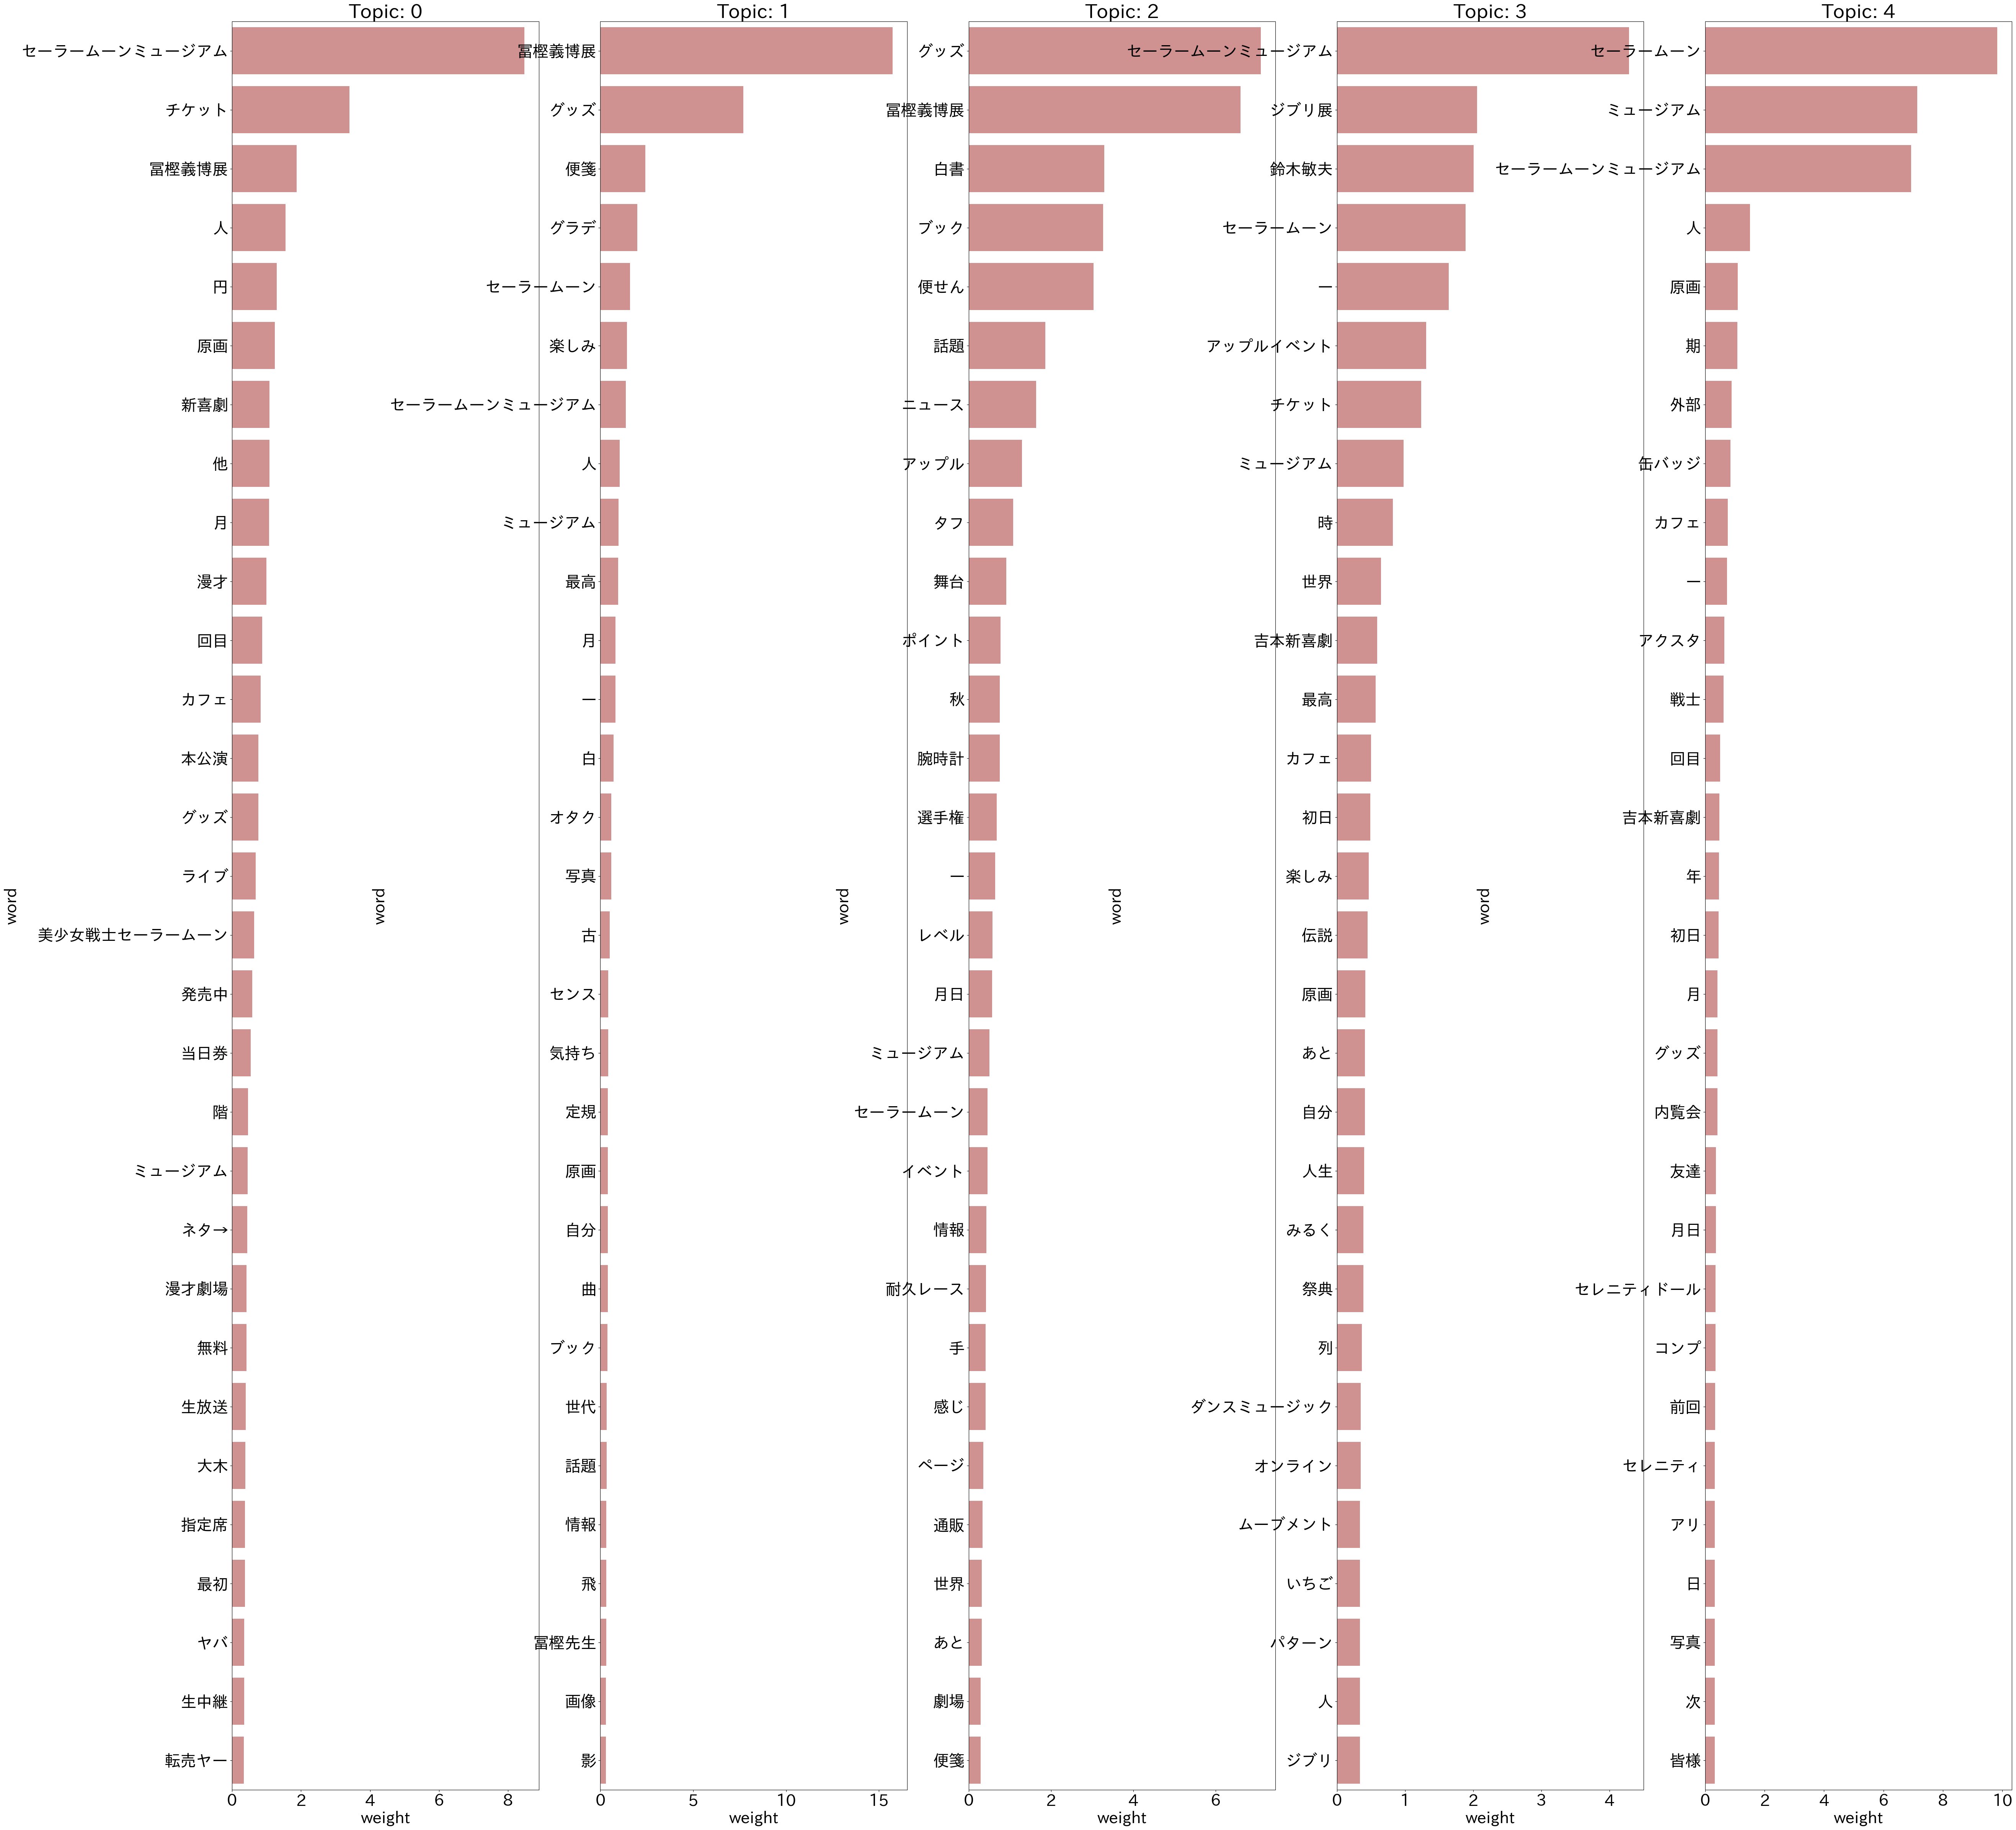

In [98]:
import matplotlib.pyplot as plt
import japanize_matplotlib
import seaborn as sns
plt.rcParams["font.size"] = 30
fig, axes = plt.subplots(1, 5, figsize=(60, 60))
topic = 0
for ax in axes.ravel()[0:]:
    sns.barplot(x="weight", y="word", data=topic_df.query('topic==@topic'), color='#da8886', ax=ax)
    ax.set_title(f'Topic: {topic}')
    topic += 1
plt.show()